In [2]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun
import scipy.stats as stats
import scipy.optimize as optimize
import warnings

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [7]:
class WeibullDemandGenerator:
   def __init__(self, num_samples, periods):
       self.num_samples = num_samples
       self.periods = periods

   def estimate_weibull_scale(self, samples, M, n_tail_buckets=3, fixed_lambda=None):
       if fixed_lambda is not None:
           return fixed_lambda
           
       flat_samples = samples.flatten()
       tail_samples = flat_samples[(flat_samples >= M-n_tail_buckets) & (flat_samples <= M)]
       n_at_threshold = np.sum(flat_samples == M)
       
       def neg_log_likelihood(scale):
           eps = 1e-10
           scale = max(scale, eps)
           
           uncensored = tail_samples[tail_samples < M]
           pdf_term = np.sum(np.log(eps + stats.weibull_min.pdf(
               uncensored - (M-n_tail_buckets), 
               c=self.k,
               scale=scale
           )))
           
           if n_at_threshold > 0:
               sf = stats.weibull_min.sf(n_tail_buckets - 1, c=self.k, scale=scale)
               threshold_term = n_at_threshold * np.log(eps + sf)
           else:
               threshold_term = 0
               
           return -(pdf_term + threshold_term)
       
       result = optimize.minimize_scalar(
           neg_log_likelihood, 
           bounds=(1e-6, 20), 
           method='bounded',
           options={'xatol': 1e-8}
       )

       if not result.success:
           warnings.warn(f"Scale estimation did not converge: {result.message}")
           
       return result.x

   def fit_and_sample(self, problem_params, demand_params, seed=None):
       if seed is not None:
           np.random.seed(seed)
       
       M = problem_params.get('censoring_threshold', 7)
       fixed_lambda = problem_params.get('weibull_fixed_lambda', None)
       self.k = problem_params.get('weibull_k', 2.0)
       n_tail_buckets = problem_params.get('n_tail_buckets', 3)
       
       orig_samples = np.random.poisson(
           demand_params['mean'], 
           size=(self.num_samples, problem_params['n_stores'], self.periods)
       )
       
       imputed_samples = np.minimum(orig_samples, M)
       censored_mask = orig_samples >= M
       
       weibull_scale = self.estimate_weibull_scale(orig_samples, M, n_tail_buckets, fixed_lambda)
       
       n_censored = np.sum(censored_mask)
       lower_bound = stats.weibull_min.cdf(n_tail_buckets, c=self.k, scale=weibull_scale)
       uniform_samples = np.random.uniform(lower_bound, 1-1e-10, size=n_censored)
       
       censored_tails = np.floor(
           M + stats.weibull_min.ppf(uniform_samples, c=self.k, scale=weibull_scale) - n_tail_buckets
       ).astype(int)
       
       imputed_samples[censored_mask] = censored_tails
       
       return orig_samples, imputed_samples

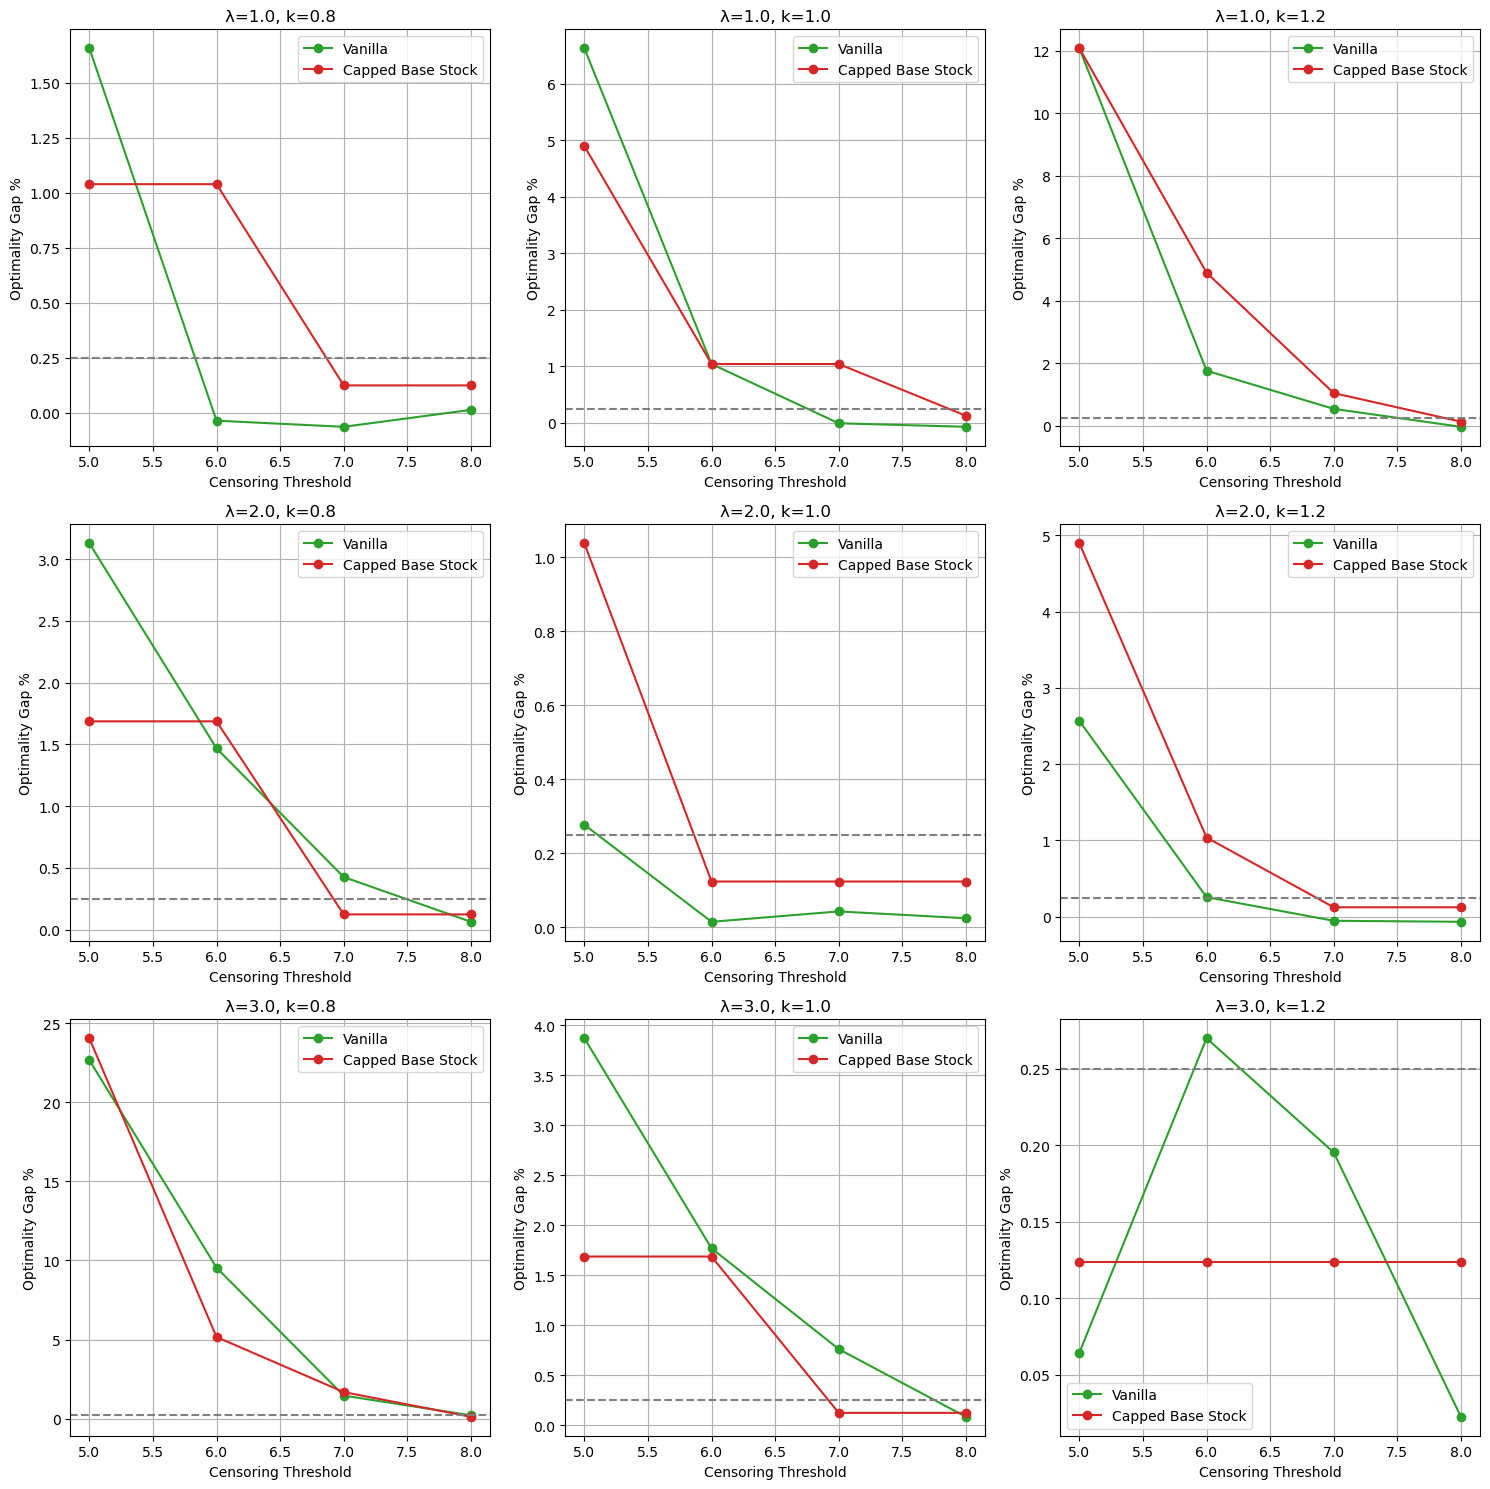

In [2]:
# Define color scheme for architecture types
color_scheme = {
    "Vanilla": "#2ca02c",  # Green
    "Capped Base Stock": "#d62728",  # Red
}

linestyle_scheme = {
    "Vanilla": "-",  # Solid
    "Capped Base Stock": "-",  # Solid
}

path = 'censored_demands'
vanilla_paths = {
    1: f'/user/ml4723/Prj/NIC/ray_results/{path}/vanilla_one_store/'
}

capped_base_stock_paths = {
    1: f'/user/ml4723/Prj/NIC/ray_results/{path}/capped_base_stock/',
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    if condition_name == 'store_lead_time':
        return 2
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

results_interpretor = rri.RayResultsinterpreter()

# Create figure with 9 subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

weibull_fixed_lambdas = [1.0, 2.0, 3.0]
weibull_ks = [0.8, 1.0, 1.2]
optimal_loss = 4.40  # Using lead time 2 optimal loss

for i, lambda_val in enumerate(weibull_fixed_lambdas):
    for j, k_val in enumerate(weibull_ks):
        # Get data for this lambda and k combination
        dfs = []
        censoring_threshold = [5, 6, 7, 8]
        
        df_vanilla = results_interpretor.make_table(vanilla_paths,
            {'censoring_threshold': censoring_threshold, 
             'weibull_fixed_lambda': [lambda_val],
             'weibull_k': [k_val],
             'store_lead_time': [2]},
            default_condition_setter, custom_data_filler, 
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
        
        df_vanilla.insert(2, 'Architecture Class', "Vanilla")
        df_vanilla['Optimality Gap %'] = ((df_vanilla['Test Loss'] - optimal_loss) / optimal_loss) * 100
        
        df_capped = results_interpretor.make_table(capped_base_stock_paths,
            {'censoring_threshold': censoring_threshold,
             'weibull_fixed_lambda': [lambda_val],
             'weibull_k': [k_val],
             'store_lead_time': [2]},
            default_condition_setter, custom_data_filler,
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
        
        df_capped.insert(2, 'Architecture Class', "Capped Base Stock")
        df_capped['Optimality Gap %'] = ((df_capped['Test Loss'] - optimal_loss) / optimal_loss) * 100
        
        # Plot optimality gaps
        for arch, df in [("Vanilla", df_vanilla), ("Capped Base Stock", df_capped)]:
            x = df['censoring_threshold'].to_numpy()
            y = df['Optimality Gap %'].to_numpy()
            axs[i,j].plot(x, y,
                    marker='o', label=arch, 
                    color=color_scheme[arch],
                    linestyle=linestyle_scheme[arch])
        
        axs[i,j].set_xlabel('Censoring Threshold')
        axs[i,j].set_ylabel('Optimality Gap %')
        axs[i,j].set_title(f'λ={lambda_val}, k={k_val}')
        axs[i,j].grid(True)
        axs[i,j].legend()

        # Add 0.25% optimality gap reference line
        axs[i,j].axhline(y=0.25, color='gray', linestyle='--', alpha=1.0, label='0.25% Gap')

plt.tight_layout()
plt.show()

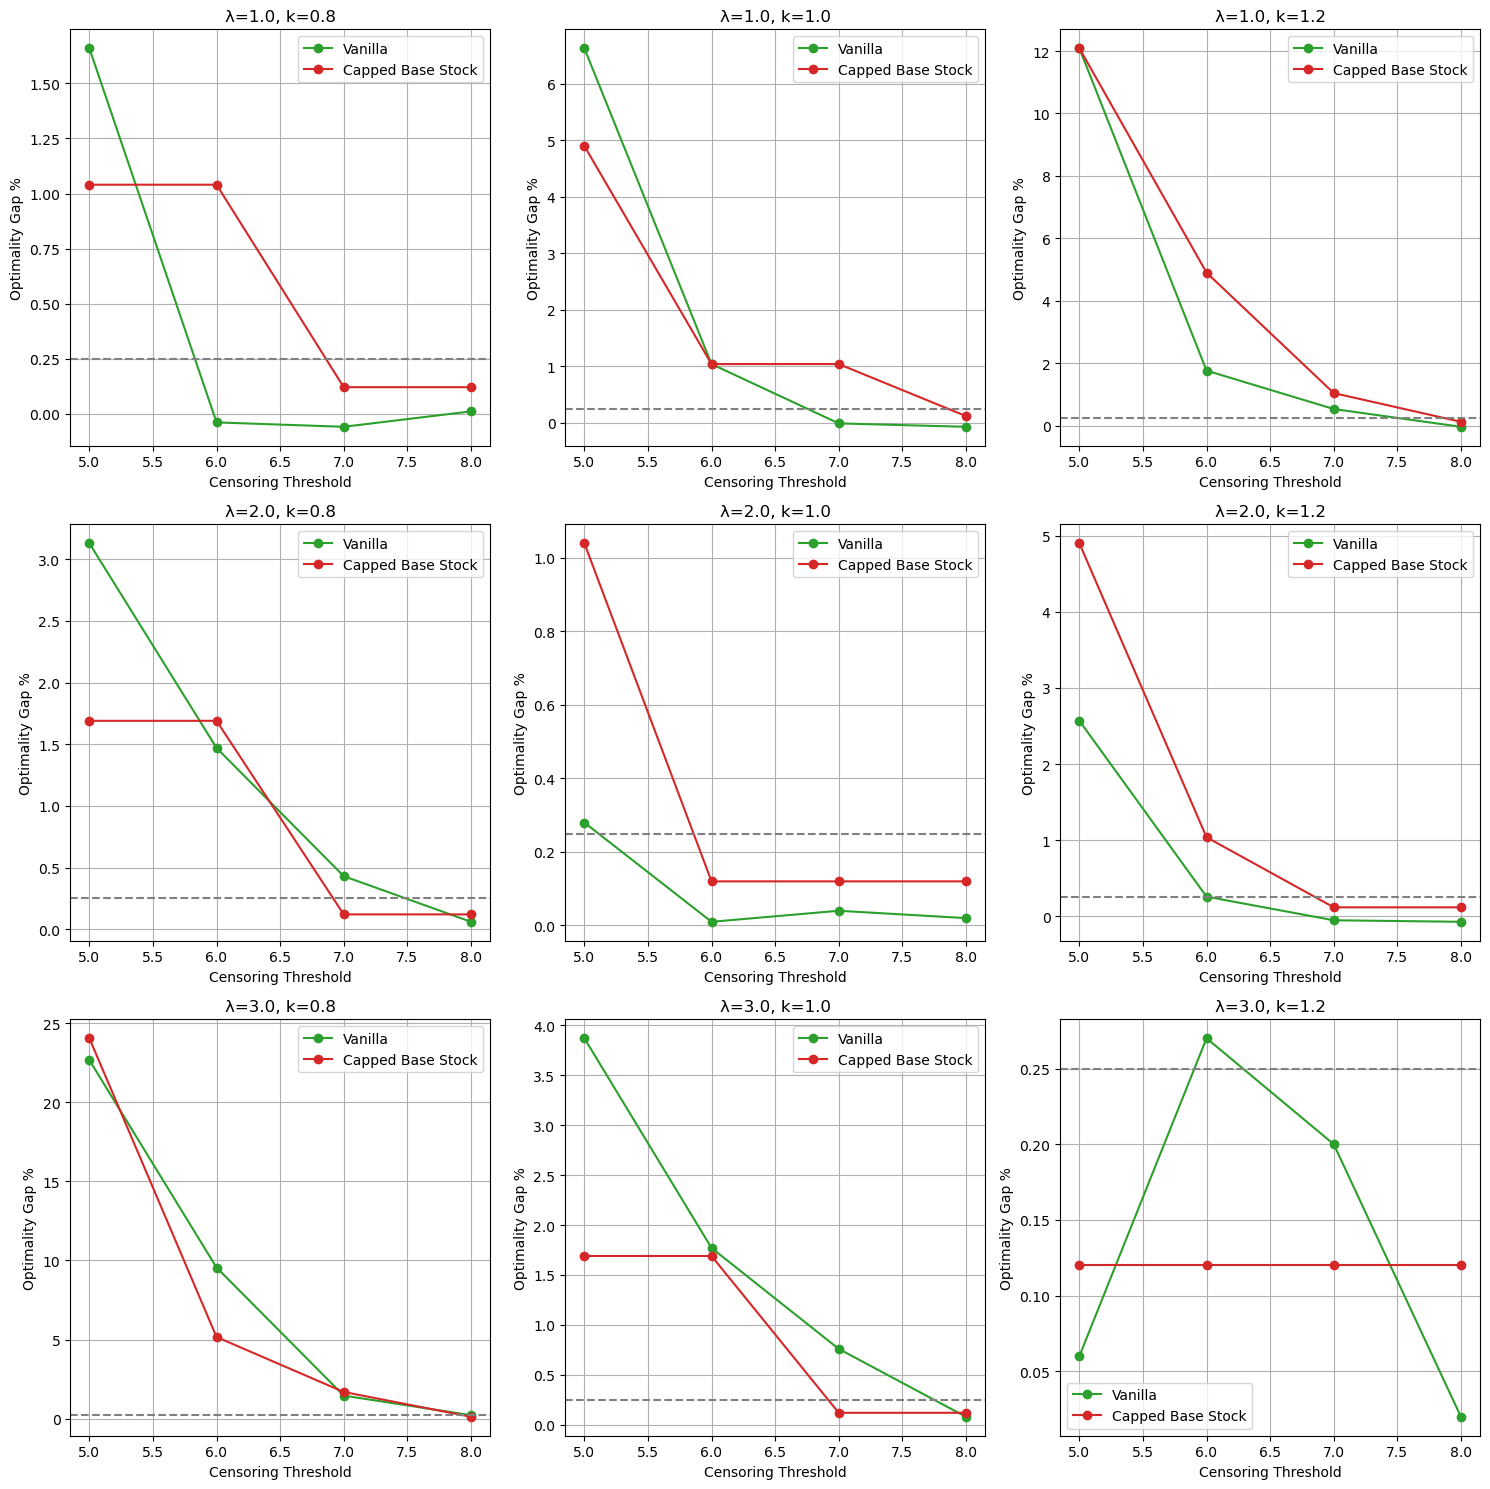

In [30]:
# Define color scheme for architecture types
color_scheme = {
    "Vanilla": "#2ca02c",  # Green
    "Capped Base Stock": "#d62728",  # Red
}

linestyle_scheme = {
    "Vanilla": "-",  # Solid
    "Capped Base Stock": "-",  # Solid
}

# Create figure with 9 subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

weibull_fixed_lambdas = [1.0, 2.0, 3.0]
weibull_ks = [0.8, 1.0, 1.2]
censoring_threshold = [5, 6, 7, 8]

# Data dictionary containing optimality gaps
data = {
    (1.0, 0.8): {
        "Vanilla": [1.66, -0.04, -0.06, 0.01],
        "Capped Base Stock": [1.04, 1.04, 0.12, 0.12]
    },
    (1.0, 1.0): {
        "Vanilla": [6.63, 1.04, -0.01, -0.07],
        "Capped Base Stock": [4.90, 1.04, 1.04, 0.12]
    },
    (1.0, 1.2): {
        "Vanilla": [12.09, 1.76, 0.53, -0.04],
        "Capped Base Stock": [12.09, 4.90, 1.04, 0.12]
    },
    (2.0, 0.8): {
        "Vanilla": [3.13, 1.47, 0.43, 0.06],
        "Capped Base Stock": [1.69, 1.69, 0.12, 0.12]
    },
    (2.0, 1.0): {
        "Vanilla": [0.28, 0.01, 0.04, 0.02],
        "Capped Base Stock": [1.04, 0.12, 0.12, 0.12]
    },
    (2.0, 1.2): {
        "Vanilla": [2.57, 0.26, -0.05, -0.07],
        "Capped Base Stock": [4.90, 1.04, 0.12, 0.12]
    },
    (3.0, 0.8): {
        "Vanilla": [22.66, 9.55, 1.46, 0.22],
        "Capped Base Stock": [24.04, 5.16, 1.69, 0.12]
    },
    (3.0, 1.0): {
        "Vanilla": [3.87, 1.77, 0.76, 0.08],
        "Capped Base Stock": [1.69, 1.69, 0.12, 0.12]
    },
    (3.0, 1.2): {
        "Vanilla": [0.06, 0.27, 0.20, 0.02],
        "Capped Base Stock": [0.12, 0.12, 0.12, 0.12]
    }
}

for i, lambda_val in enumerate(weibull_fixed_lambdas):
    for j, k_val in enumerate(weibull_ks):
        # Plot optimality gaps
        for arch in ["Vanilla", "Capped Base Stock"]:
            x = censoring_threshold
            y = data[(lambda_val, k_val)][arch]
            axs[i,j].plot(x, y,
                    marker='o', label=arch, 
                    color=color_scheme[arch],
                    linestyle=linestyle_scheme[arch])
        
        axs[i,j].set_xlabel('Censoring Threshold')
        axs[i,j].set_ylabel('Optimality Gap %')
        axs[i,j].set_title(f'λ={lambda_val}, k={k_val}')
        axs[i,j].grid(True)
        axs[i,j].legend()

        # Add 0.25% optimality gap reference line
        axs[i,j].axhline(y=0.25, color='gray', linestyle='--', alpha=1.0, label='0.25% Gap')

plt.tight_layout()
plt.show()

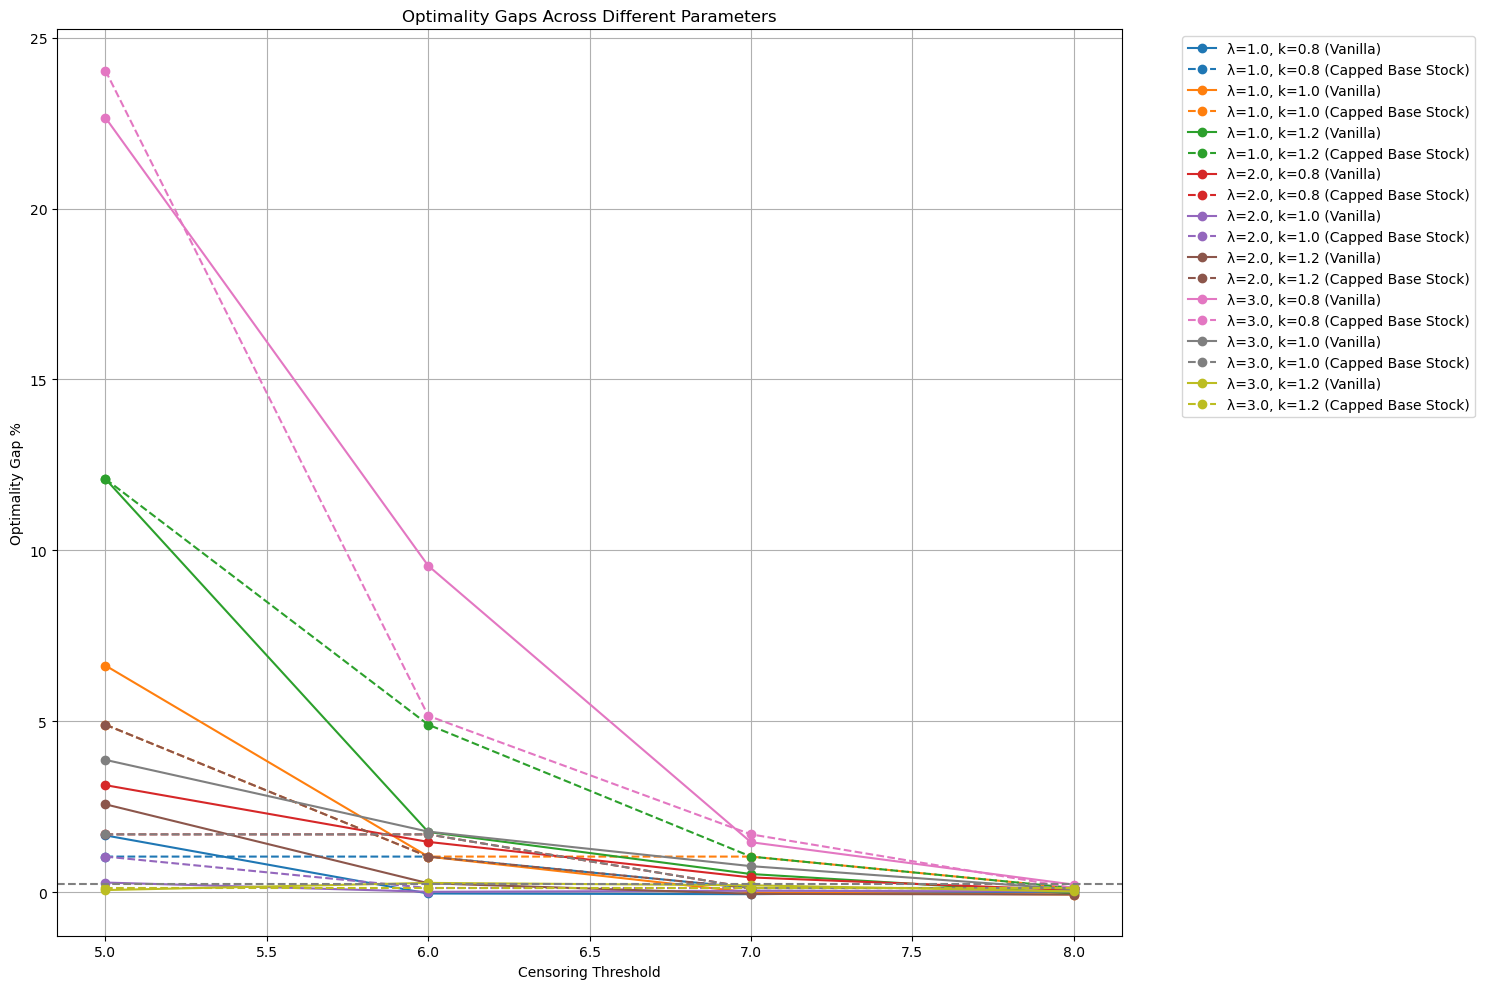

In [29]:
# Define color scheme for architecture types
color_scheme = {
    (1.0, 0.8): "#1f77b4",  # Blue
    (1.0, 1.0): "#ff7f0e",  # Orange 
    (1.0, 1.2): "#2ca02c",  # Green
    (2.0, 0.8): "#d62728",  # Red
    (2.0, 1.0): "#9467bd",  # Purple
    (2.0, 1.2): "#8c564b",  # Brown
    (3.0, 0.8): "#e377c2",  # Pink
    (3.0, 1.0): "#7f7f7f",  # Gray
    (3.0, 1.2): "#bcbd22",  # Yellow-green
}

linestyle_scheme = {
    "Vanilla": "-",      # Solid
    "Capped Base Stock": "--"  # Dashed
}

# Create single plot
fig, ax = plt.subplots(figsize=(15, 10))

weibull_fixed_lambdas = [1.0, 2.0, 3.0]
weibull_ks = [0.8, 1.0, 1.2]
censoring_threshold = [5, 6, 7, 8]

# Data from file context
data = {
    (1.0, 0.8): {
        "Vanilla": [1.66, -0.04, -0.06, 0.01],
        "Capped Base Stock": [1.04, 1.04, 0.12, 0.12]
    },
    (1.0, 1.0): {
        "Vanilla": [6.63, 1.04, -0.01, -0.07],
        "Capped Base Stock": [4.90, 1.04, 1.04, 0.12]
    },
    (1.0, 1.2): {
        "Vanilla": [12.09, 1.76, 0.53, -0.04],
        "Capped Base Stock": [12.09, 4.90, 1.04, 0.12]
    },
    (2.0, 0.8): {
        "Vanilla": [3.13, 1.47, 0.43, 0.06],
        "Capped Base Stock": [1.69, 1.69, 0.12, 0.12]
    },
    (2.0, 1.0): {
        "Vanilla": [0.28, 0.01, 0.04, 0.02],
        "Capped Base Stock": [1.04, 0.12, 0.12, 0.12]
    },
    (2.0, 1.2): {
        "Vanilla": [2.57, 0.26, -0.05, -0.07],
        "Capped Base Stock": [4.90, 1.04, 0.12, 0.12]
    },
    (3.0, 0.8): {
        "Vanilla": [22.66, 9.55, 1.46, 0.22],
        "Capped Base Stock": [24.04, 5.16, 1.69, 0.12]
    },
    (3.0, 1.0): {
        "Vanilla": [3.87, 1.77, 0.76, 0.08],
        "Capped Base Stock": [1.69, 1.69, 0.12, 0.12]
    },
    (3.0, 1.2): {
        "Vanilla": [0.06, 0.27, 0.20, 0.02],
        "Capped Base Stock": [0.12, 0.12, 0.12, 0.12]
    }
}

for lambda_val in weibull_fixed_lambdas:
    for k_val in weibull_ks:
        # Plot optimality gaps for both architectures
        for arch in ["Vanilla", "Capped Base Stock"]:
            y = data[(lambda_val, k_val)][arch]
            ax.plot(censoring_threshold, y,
                    marker='o', 
                    label=f'λ={lambda_val}, k={k_val} ({arch})',
                    color=color_scheme[(lambda_val, k_val)],
                    linestyle=linestyle_scheme[arch])

ax.set_xlabel('Censoring Threshold')
ax.set_ylabel('Optimality Gap %')
ax.set_title('Optimality Gaps Across Different Parameters')
ax.grid(True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add 0.25% optimality gap reference line
ax.axhline(y=0.25, color='gray', linestyle='--', alpha=1.0, label='0.25% Gap')

plt.tight_layout()
plt.show()

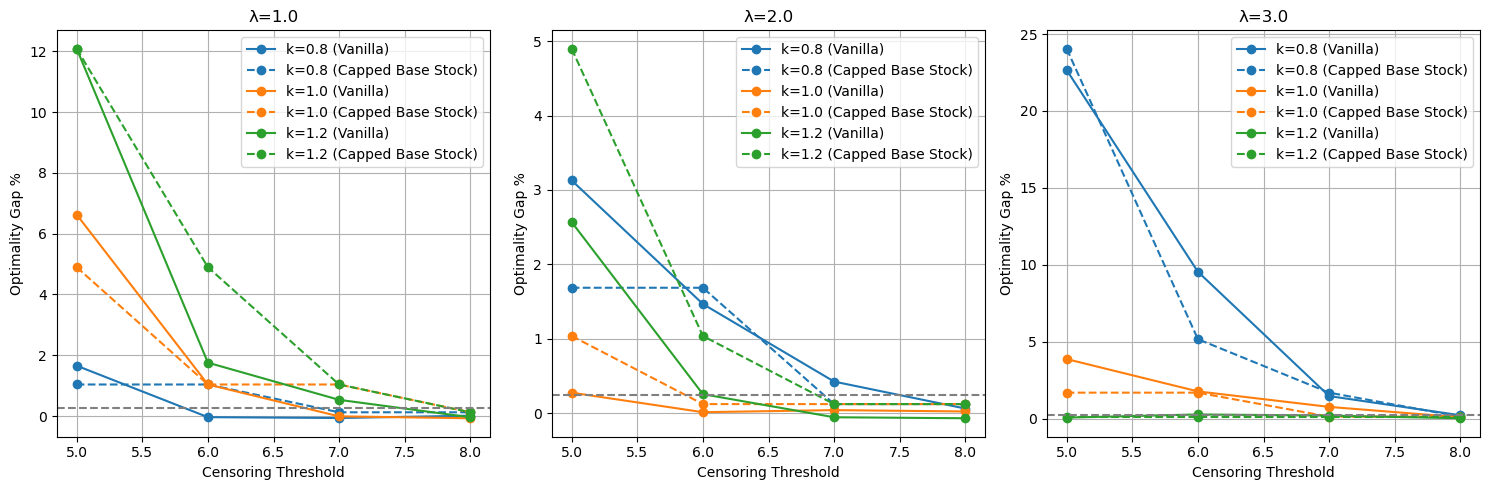

In [27]:
# Define color scheme for architecture types
color_scheme = {
    0.8: "#1f77b4",  # Blue
    1.0: "#ff7f0e",  # Orange 
    1.2: "#2ca02c",  # Green
}

linestyle_scheme = {
    "Vanilla": "-",      # Solid
    "Capped Base Stock": "--"  # Dashed
}

path = 'censored_demands'
vanilla_paths = {
    1: f'/user/ml4723/Prj/NIC/ray_results/{path}/vanilla_one_store/'
}

capped_base_stock_paths = {
    1: f'/user/ml4723/Prj/NIC/ray_results/{path}/capped_base_stock/',
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    if condition_name == 'store_lead_time':
        return 2
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

results_interpretor = rri.RayResultsinterpreter()

# Create three subplots, one for each lambda
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

weibull_fixed_lambdas = [1.0, 2.0, 3.0]
weibull_ks = [0.8, 1.0, 1.2]
optimal_loss = 4.40  # Using lead time 2 optimal loss

# First pass to get max y value
max_gap = float('-inf')
all_data = []
for lambda_val in weibull_fixed_lambdas:
    for k_val in weibull_ks:
        censoring_threshold = [5, 6, 7, 8]
        
        df_vanilla = results_interpretor.make_table(vanilla_paths,
            {'censoring_threshold': censoring_threshold, 
             'weibull_fixed_lambda': [lambda_val],
             'weibull_k': [k_val],
             'store_lead_time': [2]},
            default_condition_setter, custom_data_filler, 
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
        df_vanilla['Optimality Gap %'] = ((df_vanilla['Test Loss'] - optimal_loss) / optimal_loss) * 100
        
        df_capped = results_interpretor.make_table(capped_base_stock_paths,
            {'censoring_threshold': censoring_threshold,
             'weibull_fixed_lambda': [lambda_val],
             'weibull_k': [k_val],
             'store_lead_time': [2]},
            default_condition_setter, custom_data_filler,
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
        df_capped['Optimality Gap %'] = ((df_capped['Test Loss'] - optimal_loss) / optimal_loss) * 100
        
        max_gap = max(max_gap, df_vanilla['Optimality Gap %'].max(), df_capped['Optimality Gap %'].max())
        all_data.append((lambda_val, k_val, df_vanilla, df_capped))

# Second pass to plot with consistent y-axis
for lambda_idx, lambda_val in enumerate(weibull_fixed_lambdas):
    for lambda_val_data, k_val, df_vanilla, df_capped in all_data:
        if lambda_val_data != lambda_val:
            continue
            
        df_vanilla.insert(2, 'Architecture Class', "Vanilla")
        df_capped.insert(2, 'Architecture Class', "Capped Base Stock")
        
        # Plot optimality gaps
        for arch, df in [("Vanilla", df_vanilla), ("Capped Base Stock", df_capped)]:
            x = df['censoring_threshold'].to_numpy()
            y = df['Optimality Gap %'].to_numpy()
            axs[lambda_idx].plot(x, y,
                    marker='o', 
                    label=f'k={k_val} ({arch})',
                    color=color_scheme[k_val],
                    linestyle=linestyle_scheme[arch])

    axs[lambda_idx].set_xlabel('Censoring Threshold')
    axs[lambda_idx].set_ylabel('Optimality Gap %')
    axs[lambda_idx].set_title(f'λ={lambda_val}')
    axs[lambda_idx].grid(True)
    axs[lambda_idx].legend()
    # axs[lambda_idx].set_ylim(top=25)  # Set y-axis max to 25

    # Add 0.25% optimality gap reference line
    axs[lambda_idx].axhline(y=0.25, color='gray', linestyle='--', alpha=1.0, label='0.25% Gap')

plt.tight_layout()
plt.show()

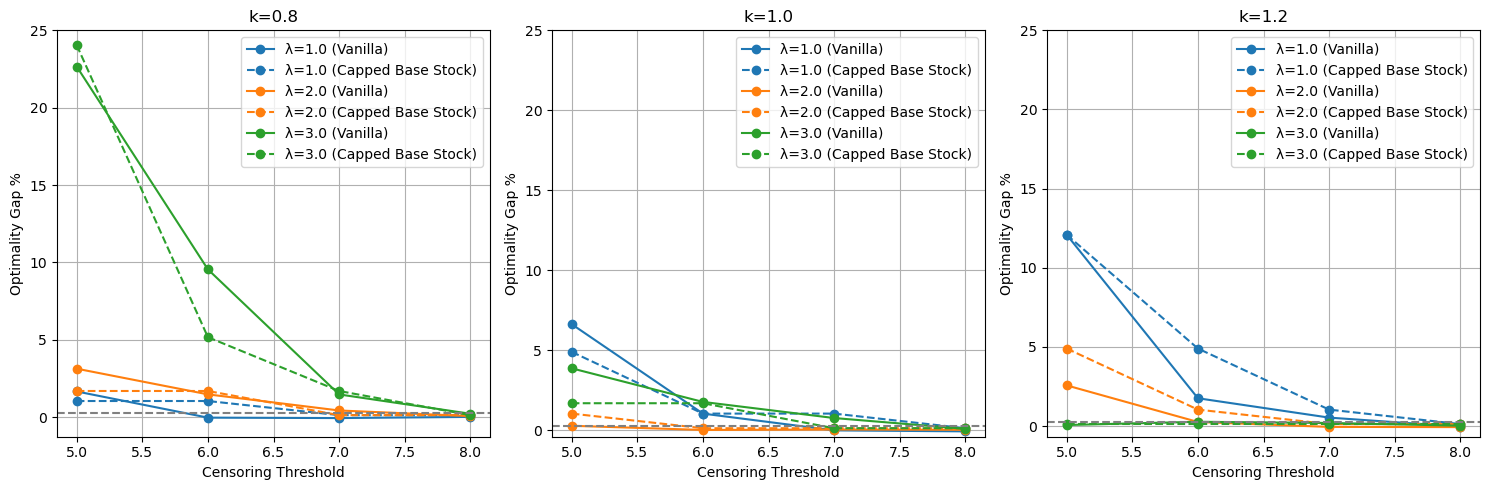

In [26]:
# Define color scheme for architecture types
color_scheme = {
    1.0: "#1f77b4",  # Blue
    2.0: "#ff7f0e",  # Orange
    3.0: "#2ca02c",  # Green
}

linestyle_scheme = {
    "Vanilla": "-",      # Solid
    "Capped Base Stock": "--"  # Dashed
}

path = 'censored_demands'
vanilla_paths = {
    1: f'/user/ml4723/Prj/NIC/ray_results/{path}/vanilla_one_store/'
}

capped_base_stock_paths = {
    1: f'/user/ml4723/Prj/NIC/ray_results/{path}/capped_base_stock/',
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    if condition_name == 'store_lead_time':
        return 2
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

results_interpretor = rri.RayResultsinterpreter()

# Create three subplots, one for each k
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

weibull_fixed_lambdas = [1.0, 2.0, 3.0]
weibull_ks = [0.8, 1.0, 1.2]
optimal_loss = 4.40  # Using lead time 2 optimal loss

for k_idx, k_val in enumerate(weibull_ks):
    for lambda_val in weibull_fixed_lambdas:
        # Get data for this lambda and k combination
        dfs = []
        censoring_threshold = [5, 6, 7, 8]
        
        df_vanilla = results_interpretor.make_table(vanilla_paths,
            {'censoring_threshold': censoring_threshold, 
             'weibull_fixed_lambda': [lambda_val],
             'weibull_k': [k_val],
             'store_lead_time': [2]},
            default_condition_setter, custom_data_filler, 
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
        
        df_vanilla.insert(2, 'Architecture Class', "Vanilla")
        df_vanilla['Optimality Gap %'] = ((df_vanilla['Test Loss'] - optimal_loss) / optimal_loss) * 100
        
        df_capped = results_interpretor.make_table(capped_base_stock_paths,
            {'censoring_threshold': censoring_threshold,
             'weibull_fixed_lambda': [lambda_val],
             'weibull_k': [k_val],
             'store_lead_time': [2]},
            default_condition_setter, custom_data_filler,
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
        
        df_capped.insert(2, 'Architecture Class', "Capped Base Stock")
        df_capped['Optimality Gap %'] = ((df_capped['Test Loss'] - optimal_loss) / optimal_loss) * 100
        
        # Plot optimality gaps
        for arch, df in [("Vanilla", df_vanilla), ("Capped Base Stock", df_capped)]:
            x = df['censoring_threshold'].to_numpy()
            y = df['Optimality Gap %'].to_numpy()
            axs[k_idx].plot(x, y,
                    marker='o', 
                    label=f'λ={lambda_val} ({arch})',
                    color=color_scheme[lambda_val],
                    linestyle=linestyle_scheme[arch])

    axs[k_idx].set_xlabel('Censoring Threshold')
    axs[k_idx].set_ylabel('Optimality Gap %')
    axs[k_idx].set_title(f'k={k_val}')
    axs[k_idx].set_ylim(top=25)
    axs[k_idx].grid(True)
    axs[k_idx].legend()

    # Add 0.25% optimality gap reference line
    axs[k_idx].axhline(y=0.25, color='gray', linestyle='--', alpha=1.0, label='0.25% Gap')

plt.tight_layout()
plt.show()

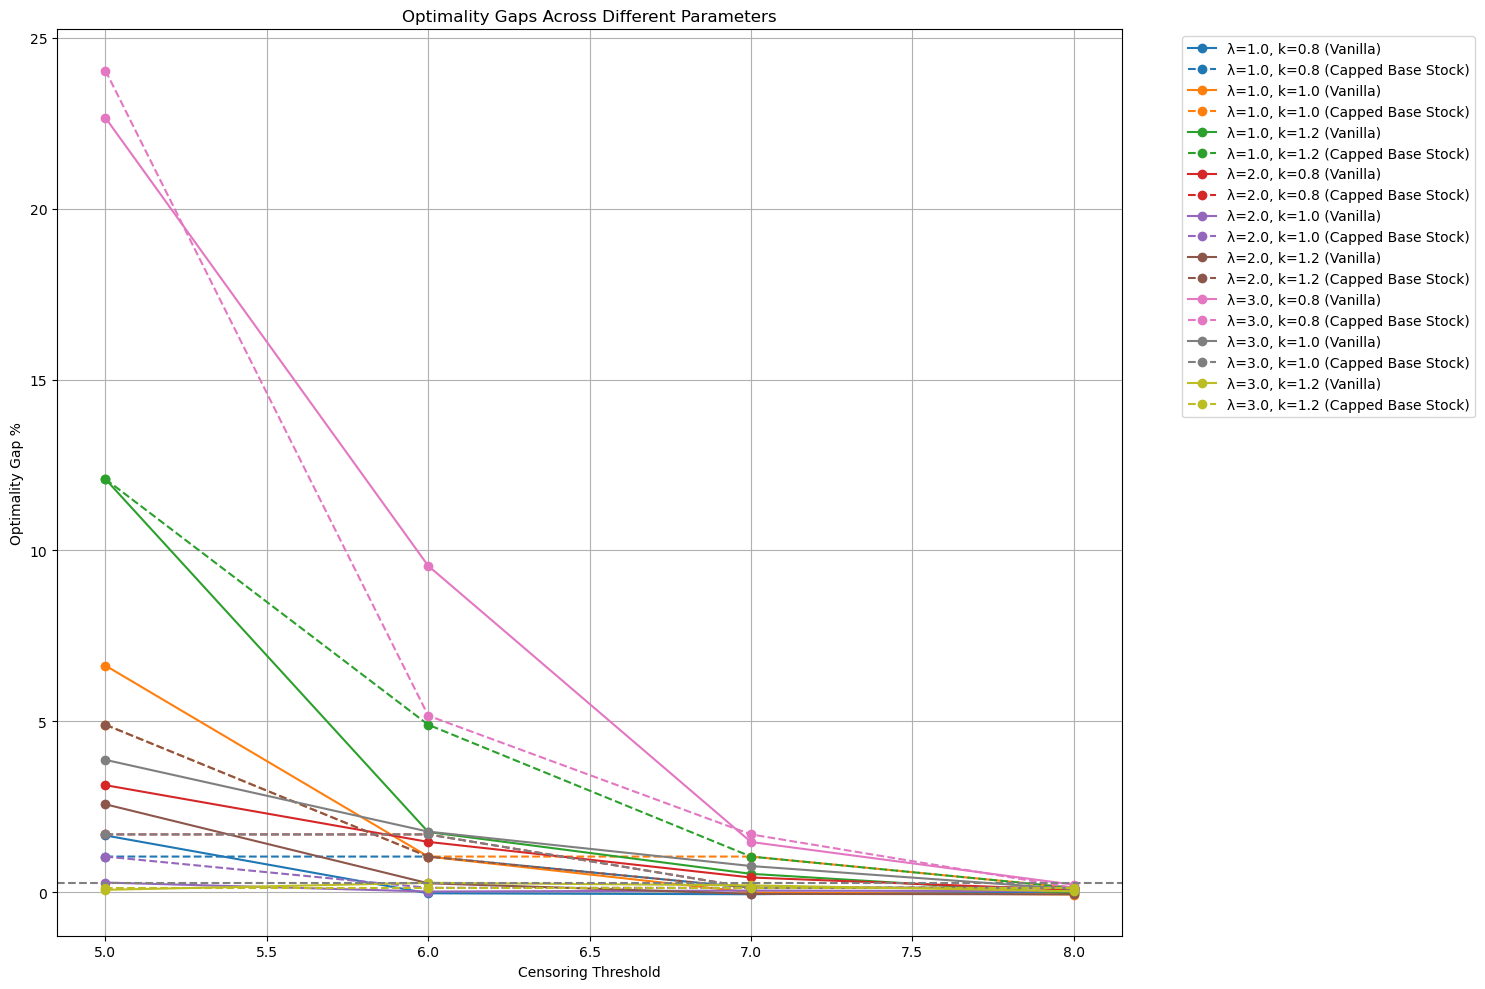

In [15]:
# Define color scheme for architecture types
color_scheme = {
    (1.0, 0.8): "#1f77b4",  # Blue
    (1.0, 1.0): "#ff7f0e",  # Orange 
    (1.0, 1.2): "#2ca02c",  # Green
    (2.0, 0.8): "#d62728",  # Red
    (2.0, 1.0): "#9467bd",  # Purple
    (2.0, 1.2): "#8c564b",  # Brown
    (3.0, 0.8): "#e377c2",  # Pink
    (3.0, 1.0): "#7f7f7f",  # Gray
    (3.0, 1.2): "#bcbd22",  # Yellow-green
}

linestyle_scheme = {
    "Vanilla": "-",      # Solid
    "Capped Base Stock": "--"  # Dashed
}

path = 'censored_demands'
vanilla_paths = {
    1: f'/user/ml4723/Prj/NIC/ray_results/{path}/vanilla_one_store/'
}

capped_base_stock_paths = {
    1: f'/user/ml4723/Prj/NIC/ray_results/{path}/capped_base_stock/',
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    if condition_name == 'store_lead_time':
        return 2
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

results_interpretor = rri.RayResultsinterpreter()

# Create single plot
fig, ax = plt.subplots(figsize=(15, 10))

weibull_fixed_lambdas = [1.0, 2.0, 3.0]
weibull_ks = [0.8, 1.0, 1.2]
optimal_loss = 4.40  # Using lead time 2 optimal loss

for lambda_val in weibull_fixed_lambdas:
    for k_val in weibull_ks:
        # Get data for this lambda and k combination
        dfs = []
        censoring_threshold = [5, 6, 7, 8]
        
        df_vanilla = results_interpretor.make_table(vanilla_paths,
            {'censoring_threshold': censoring_threshold, 
             'weibull_fixed_lambda': [lambda_val],
             'weibull_k': [k_val],
             'store_lead_time': [2]},
            default_condition_setter, custom_data_filler, 
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
        
        df_vanilla.insert(2, 'Architecture Class', "Vanilla")
        df_vanilla['Optimality Gap %'] = ((df_vanilla['Test Loss'] - optimal_loss) / optimal_loss) * 100
        
        df_capped = results_interpretor.make_table(capped_base_stock_paths,
            {'censoring_threshold': censoring_threshold,
             'weibull_fixed_lambda': [lambda_val],
             'weibull_k': [k_val],
             'store_lead_time': [2]},
            default_condition_setter, custom_data_filler,
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
        
        df_capped.insert(2, 'Architecture Class', "Capped Base Stock")
        df_capped['Optimality Gap %'] = ((df_capped['Test Loss'] - optimal_loss) / optimal_loss) * 100
        
        # Plot optimality gaps
        for arch, df in [("Vanilla", df_vanilla), ("Capped Base Stock", df_capped)]:
            x = df['censoring_threshold'].to_numpy()
            y = df['Optimality Gap %'].to_numpy()
            ax.plot(x, y,
                    marker='o', 
                    label=f'λ={lambda_val}, k={k_val} ({arch})',
                    color=color_scheme[(lambda_val, k_val)],
                    linestyle=linestyle_scheme[arch])

ax.set_xlabel('Censoring Threshold')
ax.set_ylabel('Optimality Gap %')
ax.set_title('Optimality Gaps Across Different Parameters')
ax.grid(True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add 0.25% optimality gap reference line
ax.axhline(y=0.25, color='gray', linestyle='--', alpha=1.0, label='0.25% Gap')

plt.tight_layout()
plt.show()

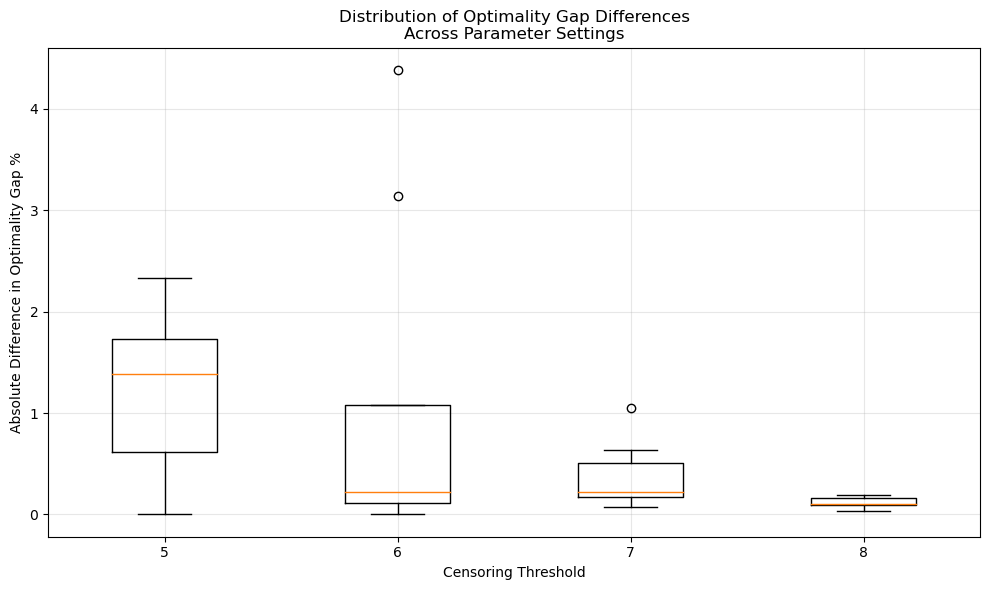

In [12]:
# Define color scheme for architecture types
color_scheme = {
    "Difference": "#1f77b4",  # Blue
}

linestyle_scheme = {
    "Difference": "-",  # Solid
}

path = 'censored_demands'
vanilla_paths = {
    1: f'/user/ml4723/Prj/NIC/ray_results/{path}/vanilla_one_store/'
}

capped_base_stock_paths = {
    1: f'/user/ml4723/Prj/NIC/ray_results/{path}/capped_base_stock/',
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    if condition_name == 'store_lead_time':
        return 2
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

results_interpretor = rri.RayResultsinterpreter()

# Create single plot
fig, ax = plt.subplots(figsize=(10, 6))

weibull_fixed_lambdas = [1.0, 2.0, 3.0]
weibull_ks = [0.8, 1.0, 1.2]
optimal_loss = 4.40  # Using lead time 2 optimal loss
censoring_threshold = [5, 6, 7, 8]

# Store differences for each threshold
threshold_differences = {t: [] for t in censoring_threshold}

# Collect differences for each parameter combination
for lambda_val in weibull_fixed_lambdas:
    for k_val in weibull_ks:
        df_vanilla = results_interpretor.make_table(vanilla_paths,
            {'censoring_threshold': censoring_threshold, 
             'weibull_fixed_lambda': [lambda_val],
             'weibull_k': [k_val],
             'store_lead_time': [2]},
            default_condition_setter, custom_data_filler, 
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
        
        df_vanilla.insert(2, 'Architecture Class', "Vanilla")
        df_vanilla['Optimality Gap %'] = ((df_vanilla['Test Loss'] - optimal_loss) / optimal_loss) * 100
        
        df_capped = results_interpretor.make_table(capped_base_stock_paths,
            {'censoring_threshold': censoring_threshold,
             'weibull_fixed_lambda': [lambda_val],
             'weibull_k': [k_val],
             'store_lead_time': [2]},
            default_condition_setter, custom_data_filler,
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
        
        df_capped.insert(2, 'Architecture Class', "Capped Base Stock")
        df_capped['Optimality Gap %'] = ((df_capped['Test Loss'] - optimal_loss) / optimal_loss) * 100

        # Calculate differences and store by threshold
        for threshold in censoring_threshold:
            vanilla_gap = df_vanilla[df_vanilla['censoring_threshold'] == threshold]['Optimality Gap %'].values[0]
            capped_gap = df_capped[df_capped['censoring_threshold'] == threshold]['Optimality Gap %'].values[0]
            threshold_differences[threshold].append(np.abs(vanilla_gap - capped_gap))

# Create box plot
box_data = [threshold_differences[t] for t in censoring_threshold]
ax.boxplot(box_data, labels=censoring_threshold)

ax.set_xlabel('Censoring Threshold')
ax.set_ylabel('Absolute Difference in Optimality Gap %')
ax.set_title('Distribution of Optimality Gap Differences\nAcross Parameter Settings')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

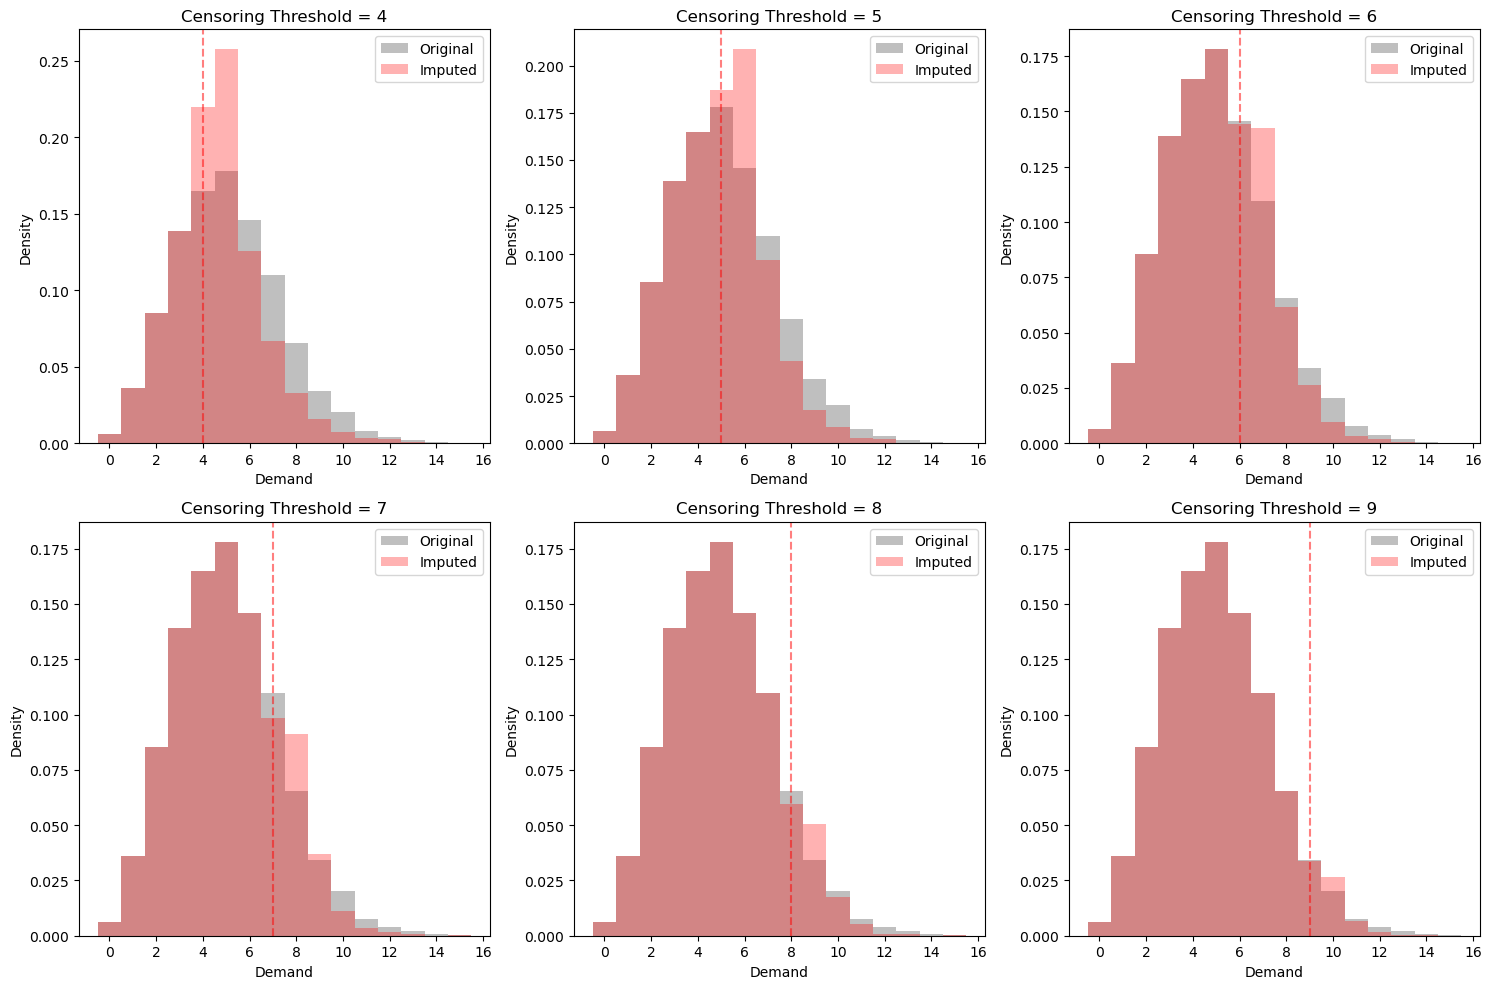

In [27]:
import scipy.stats as stats
import scipy.optimize as optimize
class PoissonDemandGenerator:
    def __init__(self, num_samples, periods):
        self.num_samples = num_samples
        self.periods = periods

    def estimate_exponential_tail_rate(self, samples, M, n_tail_buckets=3):
        flat_samples = samples.flatten()

        tail_samples = flat_samples[(flat_samples >= M-n_tail_buckets) & (flat_samples < M)]
        
        def neg_log_likelihood(rate):
            return -np.sum(np.log(stats.expon.pdf(tail_samples - (M-n_tail_buckets), scale=1/rate)))
        result = optimize.minimize_scalar(neg_log_likelihood, bounds=(0.01, 10), method='bounded')
        
        return result.x

    def generate_censored_demand(self, problem_params, demand_params, seed=None):
        if seed is not None:
            np.random.seed(seed)
        
        M = problem_params.get('censoring_threshold', 7)
        
        orig_samples = np.random.poisson(
            demand_params['mean'], 
            size=(self.num_samples, problem_params['n_stores'], self.periods)
        )
        imputed_samples = np.minimum(orig_samples, M)
        censored_mask = orig_samples >= M
        lambda_exp = self.estimate_exponential_tail_rate(orig_samples, M)
        censored_tails = np.round(
            M + np.random.exponential(1/lambda_exp, size=np.sum(censored_mask))
        ).astype(int)
        
        imputed_samples[censored_mask] = censored_tails
        return orig_samples, imputed_samples

# Create plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
thresholds = [4, 5, 6, 7, 8, 9]

generator = PoissonDemandGenerator(num_samples=8192, periods=1)
demand_params = {'mean': 5.0}

for i, M in enumerate(thresholds):
    row = i // 3
    col = i % 3
    
    problem_params = {'censoring_threshold': M, 'n_stores': 1}
    orig, imputed = generator.generate_censored_demand(problem_params, demand_params, seed=57)
    
    # Flatten arrays for histogram
    orig_flat = orig.flatten()
    imputed_flat = imputed.flatten()
    
    # Plot histograms
    bins = np.arange(0, max(orig_flat.max(), imputed_flat.max()) + 2) - 0.5
    axs[row, col].hist(orig_flat, bins=bins, alpha=0.5, density=True, label='Original', color='grey')
    axs[row, col].hist(imputed_flat, bins=bins, alpha=0.3, density=True, label='Imputed', color='red')
    
    # Add vertical line at threshold
    axs[row, col].axvline(x=M, color='r', linestyle='--', alpha=0.5)
    
    axs[row, col].set_title(f'Censoring Threshold = {M}')
    axs[row, col].set_xlabel('Demand')
    axs[row, col].set_ylabel('Density')
    axs[row, col].legend()

plt.tight_layout()
plt.show()